# Importing libraries

In [1]:
import pandas as pd
import sqlite3
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from scipy.stats import uniform 
import scipy
import warnings
warnings.filterwarnings("ignore")

In [2]:
connection= sqlite3.connect('final.sqlite')
final_data = pd.read_sql_query("select * from Reviews limit 50000 ",connection)

In [3]:
data = final_data['Text']

In [4]:
labels = final_data['Score']

In [5]:
from sklearn.model_selection import train_test_split

X_1, X_test, y_1, y_test = train_test_split(final_data['Text'], labels, test_size=0.3,shuffle=False)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

# Bag of Words

In [12]:
#Creating bag of words and vectorizing it
# We will use only unigram as trees work better when we have low dimensions data
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_features=2500,dtype=float) 
final_counts_tr = count_vect.fit_transform(X_tr.values)
final_counts_cv = count_vect.transform(X_cv.values)
final_counts_test = count_vect.transform(X_test.values)
final_counts_tr = preprocessing.normalize(final_counts_tr)
final_counts_cv = preprocessing.normalize(final_counts_cv)
final_counts_test = preprocessing.normalize(final_counts_test)

In [13]:
y_tr.value_counts()

1    20744
0     3756
Name: Score, dtype: int64

### Ranom Forest on BoW

In [94]:
base_learners = [x for x in range(1, 15,3)]
base_learners

[1, 4, 7, 10, 13]

In [140]:
# K-Fold Cross - validation .
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
cv_scores = []
for i in base_learners:
    clf = RandomForestClassifier(n_estimators = i,n_jobs=-1)
    scores = cross_val_score(clf, final_counts_tr, y_tr, cv = 3, scoring = 'accuracy')
    cv_scores.append(scores.mean())

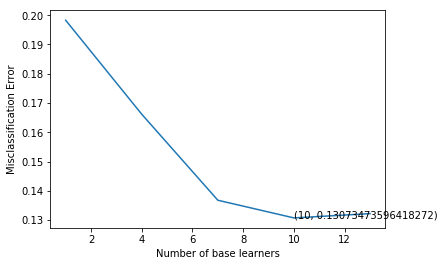

In [141]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]
optimal_learners = base_learners[error.index(min(error))]
plt.plot(base_learners, error)
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [142]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(final_counts_tr, y_tr)
clf.score(final_counts_test, y_test)

0.8822

In [145]:
pred = clf.predict(final_counts_test)

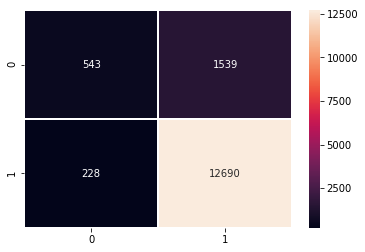

Accuracy on cv set for BoW: 88.220%
Precision on cv set for BoW: 0.892
Recall on cv set for BoW: 0.982
F1-Score on cv set for BoW: 0.935


In [146]:
conf_mat_tfidf_rs = confusion_matrix(y_test,pred)
sns.heatmap(conf_mat_tfidf_rs,annot=True,fmt="d",linewidths=.5)
plt.show()

print("Accuracy on cv set for BoW: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for BoW: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for BoW: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for BoW: %0.3f"%(f1_score(y_test, pred)))


In [20]:
import pandas as pd
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_100_pos = likelihood_df.sort_values(by='Score',ascending=True).iloc[:100]
top_100_pos.reset_index(inplace=True)
top_words_pos = top_100_pos['index']

In [21]:
top_words_pos

0        continued
1      beautifully
2        versatile
3         medicine
4              bed
5          bedtime
6              god
7             fats
8           staple
9            berry
10           feels
11          mainly
12        macaroni
13             eye
14        constant
15          losing
16    consistently
17      thoroughly
18            loma
19         finicky
20            firm
21         complex
22         lightly
23         lentils
24          follow
25        comments
26           kraft
27            loss
28            beat
29             bay
          ...     
70     ghirardelli
71        smelling
72        chipotle
73           sodas
74            skin
75           train
76          celery
77             ham
78           girls
79          cereal
80       childhood
81       chamomile
82           grill
83           child
84           grass
85            sore
86            tofu
87           sorts
88           tired
89           holds
90         holiday
91          

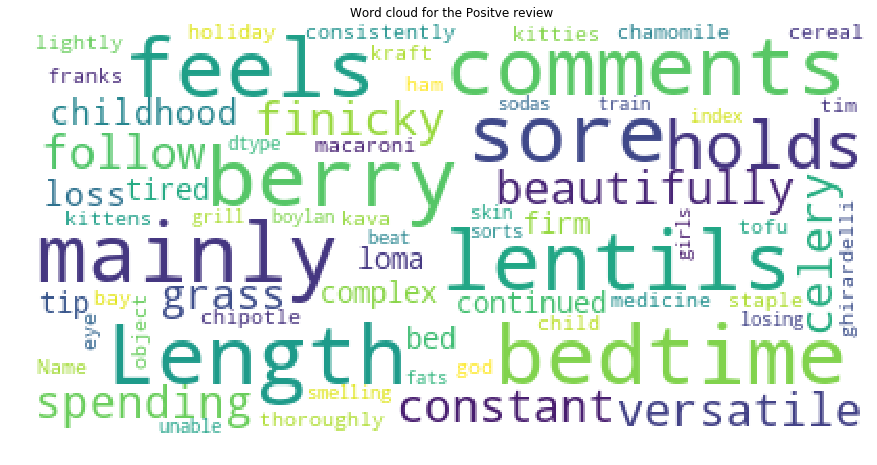

In [25]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                        max_words=100,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_words_pos))
print(wordcloud)
fig = plt.figure(1,figsize=(15,10))
plt.title("Word cloud for the Positve review")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [26]:
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_100_neg = likelihood_df.sort_values(by='Score',ascending=False).iloc[:100]
top_100_neg.reset_index(inplace=True)
top_words_neg = top_100_neg['index']

In [27]:
top_words_neg

0              not
1     disappointed
2              the
3              was
4            worst
5            money
6              and
7            great
8              did
9            waste
10              of
11         product
12              it
13           threw
14        horrible
15           awful
16          refund
17            didn
18            love
19            this
20              is
21              to
22          return
23             but
24           would
25        terrible
26            that
27              my
28             for
29            were
          ...     
70            from
71            only
72              ok
73              as
74            more
75            them
76              br
77        throwing
78          wouldn
79           worse
80            will
81         instead
82           after
83             off
84             too
85             one
86              me
87              or
88          please
89            your
90            when
91          

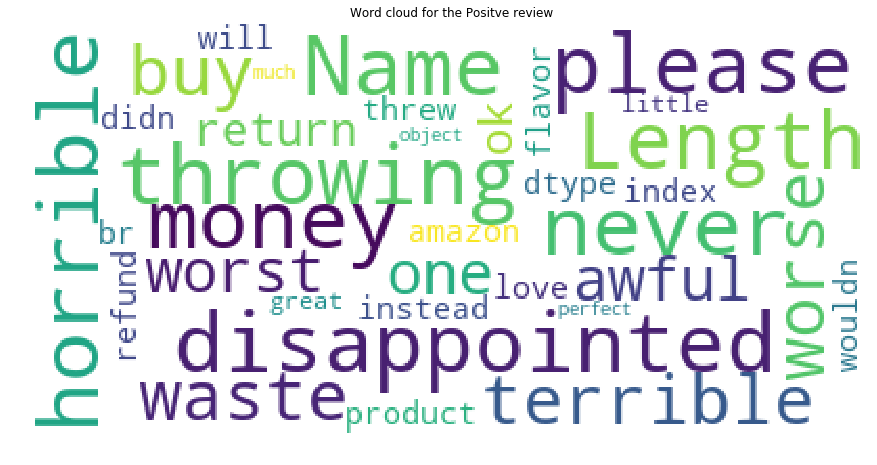

In [28]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                        max_words=100,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_words_neg))
print(wordcloud)
fig = plt.figure(1,figsize=(15,10))
plt.title("Word cloud for the Positve review")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### GDBT (Gradient Boosted Decision Tree)

In [100]:
learnnig_rate = [x/10 for x in range(1,11,2)]
learnnig_rate

[0.1, 0.3, 0.5, 0.7, 0.9]

In [101]:
max_depth = [x for x in range(1,6)]
max_depth

[1, 2, 3, 4, 5]

In [102]:
from sklearn.model_selection import GridSearchCV
#pip install xgboost
from xgboost import XGBClassifier
params = {'n_estimators': base_learners, 'learning_rate': learnnig_rate, 'max_depth': max_depth}
clf = XGBClassifier(n_jobs=-1)
model = GridSearchCV(clf, params,scoring='f1')
model.fit(final_counts_tr, y_tr)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 4, 7, 10, 13], 'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [103]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

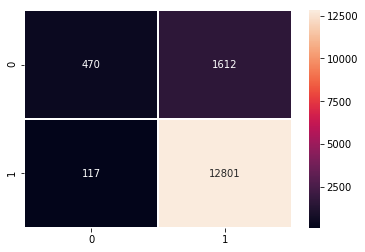

Accuracy on cv set for tf-idf: 88.473%
Precision on cv set for tf-idf: 0.888
Recall on cv set for tf-idf: 0.991
F1-Score on cv set for tf-idf: 0.937


In [106]:
pred=model.predict(tf_idf_test)

conf_mat = confusion_matrix(y_test,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("Accuracy on cv set for tf-idf: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for tf-idf: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for tf-idf: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for tf-idf: %0.3f"%(f1_score(y_test, pred)))


In [35]:
df = pd.DataFrame(model.cv_results_)

In [40]:
df1 =df[['param_max_depth','param_learning_rate','mean_test_score']]

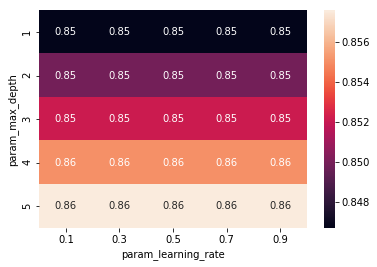

In [43]:
df1.drop_duplicates(['param_max_depth','param_learning_rate'], inplace=True)
pivot = df1.pivot(index='param_max_depth', columns='param_learning_rate', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

# TF-IDF

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(max_features=2500)
tf_idf_tr = tf_idf_vect.fit_transform(X_tr.values)
tf_idf_cv = tf_idf_vect.transform(X_cv.values)
tf_idf_test = tf_idf_vect.transform(X_test.values)

tf_idf_tr = preprocessing.normalize(tf_idf_tr)
tf_idf_cv = preprocessing.normalize(tf_idf_cv)
tf_idf_test = preprocessing.normalize(tf_idf_test)

### Ranom Forest on TFIDF

In [107]:
# K-Fold Cross - validation .
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
cv_scores = []
for i in base_learners:
    clf = RandomForestClassifier(n_estimators = i)
    scores = cross_val_score(clf, tf_idf_tr, y_tr, cv = 3, scoring = 'accuracy')
    cv_scores.append(scores.mean())

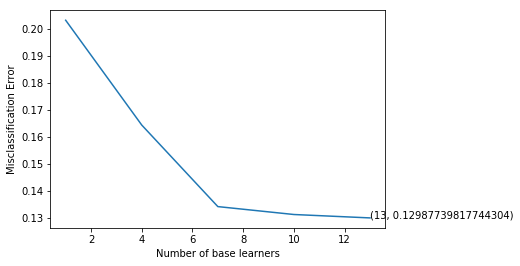

In [108]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]
optimal_learners = base_learners[error.index(min(error))]
plt.plot(base_learners, error)
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [110]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(tf_idf_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

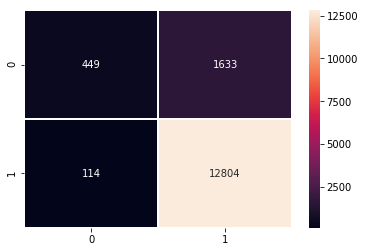

Accuracy on cv set for tf-idf: 88.353%
Precision on cv set for tf-idf: 0.887
Recall on cv set for tf-idf: 0.991
F1-Score on cv set for tf-idf: 0.936


In [111]:
pred=clf.predict(tf_idf_test)

conf_mat = confusion_matrix(y_test,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("Accuracy on cv set for tf-idf: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for tf-idf: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for tf-idf: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for tf-idf: %0.3f"%(f1_score(y_test, pred)))


In [54]:
import pandas as pd
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_100_pos = likelihood_df.sort_values(by='Score',ascending=True).iloc[:100]
top_100_pos.reset_index(inplace=True)
top_words_pos = top_100_pos['index']

In [55]:
top_words_pos

0          highest
1        developed
2        depending
3       properties
4       delightful
5           losing
6            onion
7        versatile
8             ribs
9            tacos
10            beat
11            cure
12        diabetic
13        macaroni
14      vegetarian
15          mainly
16        maintain
17          crispy
18           crisp
19          olives
20           tangy
21            tart
22        crackers
23            male
24        teaspoon
25       retriever
26           punch
27       digestion
28         disease
29          steaks
          ...     
70             mug
71            calm
72           ramen
73             cal
74           cakes
75         trouble
76         brother
77             tsp
78            tuna
79          burton
80         burgers
81         muffins
82           moist
83          unable
84      refreshing
85    concentrated
86          mellow
87        memories
88    occasionally
89        relaxing
90         thicker
91          

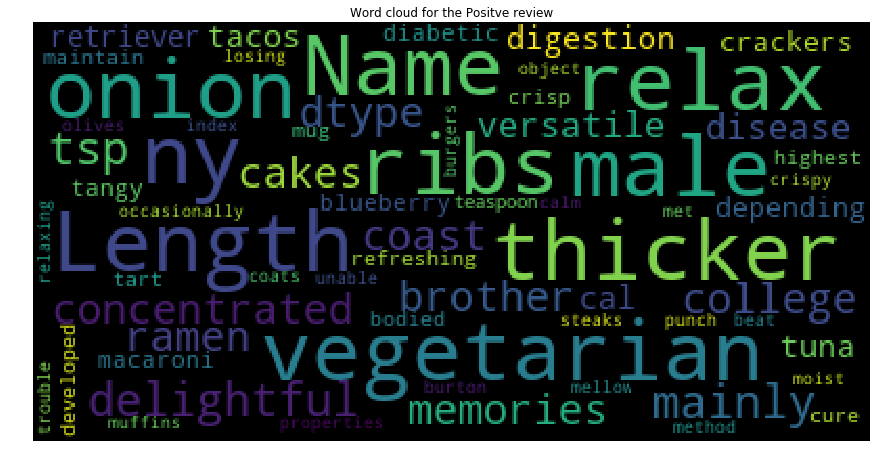

In [61]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black',
                        max_words=100,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_words_pos))
print(wordcloud)
fig = plt.figure(1,figsize=(15,10))
plt.title("Word cloud for the Positve review")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [57]:
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_100_neg = likelihood_df.sort_values(by='Score',ascending=False).iloc[:100]
top_100_neg.reset_index(inplace=True)
top_words_neg = top_100_neg['index']

In [58]:
top_words_neg

0               not
1      disappointed
2             money
3               was
4             worst
5               and
6               the
7             great
8             waste
9          terrible
10             this
11           refund
12           return
13               is
14              did
15               it
16          product
17             that
18         horrible
19             love
20               of
21              but
22          thought
23               to
24              for
25    disappointing
26            threw
27            would
28            awful
29             best
          ...      
70         received
71               ok
72            again
73             more
74          picture
75            sorry
76            trash
77            could
78              don
79          instead
80              buy
81           please
82           highly
83            these
84               as
85              all
86               br
87          minutes
88          another


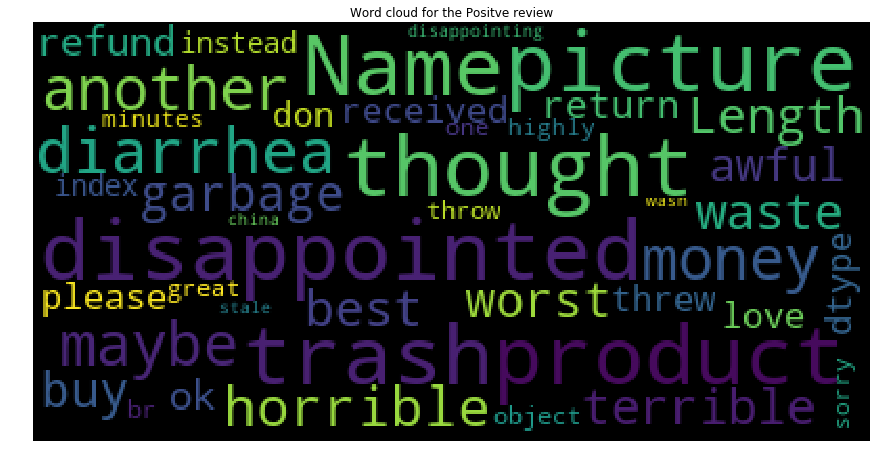

In [60]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='black',
                        max_words=100,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_words_neg))
print(wordcloud)
fig = plt.figure(1,figsize=(15,10))
plt.title("Word cloud for the Positve review")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### GDBT on TFIDF

In [112]:
from sklearn.model_selection import GridSearchCV
#pip install xgboost
from xgboost import XGBClassifier
params = {'n_estimators': base_learners, 'learning_rate': learnnig_rate, 'max_depth': max_depth}
clf = XGBClassifier()
model = GridSearchCV(clf, params,)
model.fit(tf_idf_tr, y_tr)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [1, 4, 7, 10, 13], 'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [113]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.7, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [51]:
model.score(final_counts_test, y_test)

0.8834

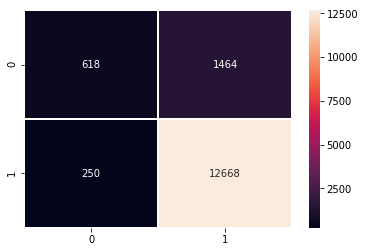

Accuracy on cv set for tf-idf: 88.573%
Precision on cv set for tf-idf: 0.896
Recall on cv set for tf-idf: 0.981
F1-Score on cv set for tf-idf: 0.937


In [114]:
pred=model.predict(tf_idf_test)

conf_mat = confusion_matrix(y_test,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("Accuracy on cv set for tf-idf: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for tf-idf: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for tf-idf: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for tf-idf: %0.3f"%(f1_score(y_test, pred)))


In [ ]:
df = pd.DataFrame(model.cv_results_)
df1 =df[['param_max_depth','param_learning_rate','mean_test_score']]

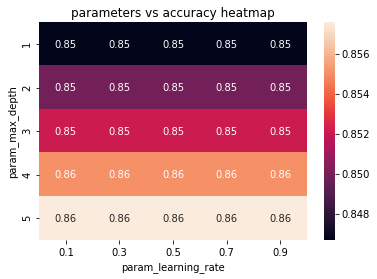

In [62]:
df1.drop_duplicates(['param_max_depth','param_learning_rate'], inplace=True)
pivot = df1.pivot(index='param_max_depth', columns='param_learning_rate', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.title("parameters vs accuracy heatmap")
plt.show()

# Avg Word2vec

In [67]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [68]:
import re
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sentence_tr=[]
for sentence in X_tr.values:
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    for words in sentence.split():
        for cleaned_words in cleanpunc(words).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentence_tr.append(filtered_sentence)

i=0
list_of_sentence_cv=[]
for sentence in X_cv.values:
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    for words in sentence.split():
        for cleaned_words in cleanpunc(words).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentence_cv.append(filtered_sentence)
i=0
list_of_sentence_test=[]
for sentence in X_test.values:
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    for words in sentence.split():
        for cleaned_words in cleanpunc(words).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentence_test.append(filtered_sentence)

In [70]:
w2v_model=gensim.models.Word2Vec(list_of_sentence_tr,min_count=5,size=50, workers=4)

In [71]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10870
sample words  ['wants', 'sealed', 'whichever', 'direction', 'cheese', 'engaging', 'um', 'cabinets', 'men', 'landed', 'absorbing', 'shells', 'whatsoever', 'sample', 'liquids', 'beyond', 'illy', 'living', 'patience', 'jarritos', 'drinks', 'breastfed', 'contributing', 'hunger', 'aid', 'tannins', 'boring', 'biz', 'puppys', 'dye', 'valley', 'exceptionally', 'skim', 'entertaining', 'tabascos', 'connect', 'staring', 'tvp', 'magical', 'increases', 'cholesterol', 'reservations', 'whove', 'pristine', 'macadamia', 'toxins', 'ie', 'h', 'experiance', 'flight']


In [72]:
import numpy as np
# average Word2Vec
# compute average word2vec for each review.
sentence_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in list_of_sentence_tr: # for each review/sentence
    sentence_vector_tr = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        try:
            vector = w2v_model.wv[word]
            sentence_vector_tr += vector
            count_words += 1
        except:
            pass
    sentence_vector_tr /= count_words
    sentence_vectors_tr.append(sentence_vector_tr)
print(len(sentence_vectors_tr))
print(len(sentence_vectors_tr[0]))

24500
50


In [73]:
import numpy as np
# average Word2Vec
# compute average word2vec for each review.
sentence_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in list_of_sentence_cv: # for each review/sentence
    sentence_vector_cv = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        try:
            vector = w2v_model.wv[word]
            sentence_vector_tr += vector
            count_words += 1
        except:
            pass
    sentence_vector_tr /= count_words
    sentence_vectors_cv.append(sentence_vector_tr)
print(len(sentence_vectors_cv))
print(len(sentence_vectors_cv[0]))

10500
50


In [74]:
import numpy as np
# average Word2Vec
# compute average word2vec for each review.
sentence_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in list_of_sentence_test: # for each review/sentence
    sentence_vector_test = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        try:
            vector = w2v_model.wv[word]
            sentence_vector_tr += vector
            count_words += 1
        except:
            pass
    sentence_vector_tr /= count_words
    sentence_vectors_test.append(sentence_vector_tr)
print(len(sentence_vectors_test))
print(len(sentence_vectors_test[0]))

15000
50


In [75]:
sentence_vectors_tr = preprocessing.normalize(sentence_vectors_tr)
sentence_vectors_cv = preprocessing.normalize(sentence_vectors_cv)
sentence_vectors_test = preprocessing.normalize(sentence_vectors_test)

### random forest on avg Word2vec

In [147]:
# K-Fold Cross - validation .
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
cv_scores = []
for i in base_learners:
    clf = RandomForestClassifier(n_estimators = i)
    scores = cross_val_score(clf, sentence_vectors_tr, y_tr, cv = 3, scoring = 'accuracy')
    cv_scores.append(scores.mean())

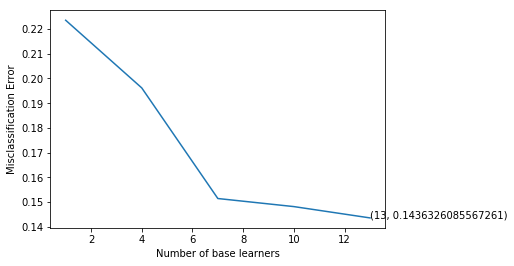

In [148]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]
optimal_learners = base_learners[error.index(min(error))]
plt.plot(base_learners, error)
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [149]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(sentence_vectors_tr, y_tr)
clf.score(sentence_vectors_test, y_test)

0.8612

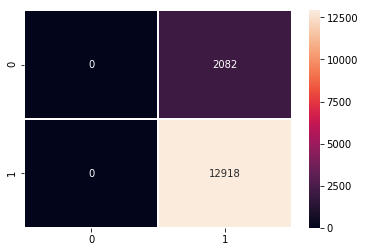

Accuracy on cv set for Avg Word2vec: 86.120%
Precision on cv set for Avg Word2vec: 0.861
Recall on cv set for Avg Word2vec: 1.000
F1-Score on cv set for Avg Word2vec: 0.925


In [150]:
pred=clf.predict(sentence_vectors_test)

conf_mat = confusion_matrix(y_test,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("Accuracy on cv set for Avg Word2vec: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for Avg Word2vec: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for Avg Word2vec: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for Avg Word2vec: %0.3f"%(f1_score(y_test, pred)))


### GDBT 

In [151]:
from sklearn.model_selection import GridSearchCV
#pip install xgboost
from xgboost import XGBClassifier
params = {'n_estimators': base_learners, 'learning_rate': learnnig_rate, 'max_depth': max_depth}
clf = XGBClassifier()
model = GridSearchCV(clf, params,n_jobs=-1)
model.fit(sentence_vectors_tr, y_tr)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1, 4, 7, 10, 13], 'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [152]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [153]:
model.score(sentence_vectors_test, y_test)

0.8612

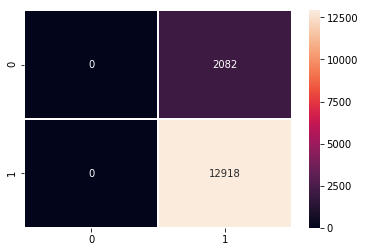

Accuracy on cv set for Avg word2vec: 86.120%
Precision on cv set for Avg word2vec: 0.861
Recall on cv set for Avg word2vec: 1.000
F1-Score on cv set for Avg word2vec: 0.925


In [154]:
pred=model.predict(sentence_vectors_test)

conf_mat = confusion_matrix(y_test,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("Accuracy on cv set for Avg word2vec: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for Avg word2vec: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for Avg word2vec: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for Avg word2vec: %0.3f"%(f1_score(y_test, pred)))


# TFIDF Avg Word2vec

In [82]:
from tqdm import tqdm

In [83]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(data.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [84]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:    
                tf_idf = dictionary[word] * sent.count(word)
            except KeyError:
                tf_idf = 0
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 24500/24500 [05:47<00:00, 70.52it/s]


In [85]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:    
                tf_idf = dictionary[word] * sent.count(word)
            except KeyError:
                tf_idf = 0
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 10500/10500 [02:27<00:00, 71.07it/s]


In [86]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:    
                tf_idf = dictionary[word] * sent.count(word)
            except KeyError:
                tf_idf = 0
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 15000/15000 [03:13<00:00, 77.41it/s] 


In [87]:
tfidf_sent_vectors_tr = preprocessing.normalize(tfidf_sent_vectors_tr)
tfidf_sent_vectors_cv = preprocessing.normalize(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test = preprocessing.normalize(tfidf_sent_vectors_test)

### Random forest

In [155]:
# K-Fold Cross - validation .
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
cv_scores = []
for i in base_learners:
    clf = RandomForestClassifier(n_estimators = i,n_jobs=-1)
    scores = cross_val_score(clf, tfidf_sent_vectors_tr, y_tr, cv = 3, scoring = 'accuracy')
    cv_scores.append(scores.mean())


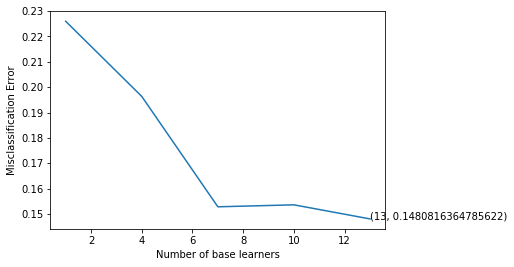

In [156]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]
optimal_learners = base_learners[error.index(min(error))]
plt.plot(base_learners, error)
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [157]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(tfidf_sent_vectors_tr, y_tr)
clf.score(tfidf_sent_vectors_test, y_test)

0.8675333333333334

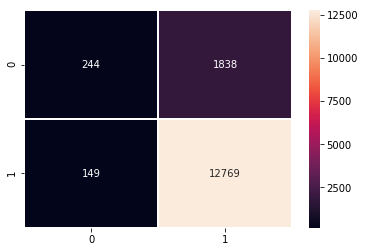

Accuracy on cv set for tf-idf avg word2vec: 86.753%
Precision on cv set for tf-idf avg word2vec: 0.874
Recall on cv set for tf-idf avg word2vec: 0.988
F1-Score on cv set for tf-idf avg word2vec: 0.928


In [158]:
pred=clf.predict(tfidf_sent_vectors_test)

conf_mat = confusion_matrix(y_test,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("Accuracy on cv set for tf-idf avg word2vec: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for tf-idf avg word2vec: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for tf-idf avg word2vec: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for tf-idf avg word2vec: %0.3f"%(f1_score(y_test, pred)))


### GBDT

In [135]:
from sklearn.model_selection import GridSearchCV
#pip install xgboost
from xgboost import XGBClassifier
params = {'n_estimators': base_learners, 'learning_rate': learnnig_rate, 'max_depth': max_depth}
clf = XGBClassifier()
model = GridSearchCV(clf, params,n_jobs=-1)
model.fit(tfidf_sent_vectors_tr, y_tr)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1, 4, 7, 10, 13], 'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [136]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [137]:
model.score(tfidf_sent_vectors_test, y_test)

0.8738666666666667

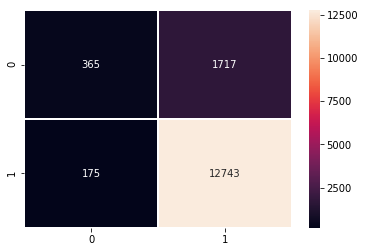

Accuracy on cv set for tf-idf avg word2vec: 87.387%
Precision on cv set for tf-idf avg word2vec: 0.881
Recall on cv set for tf-idf avg word2vec: 0.986
F1-Score on cv set for tf-idf avg word2vec: 0.931


In [144]:
pred=model.predict(tfidf_sent_vectors_test)

conf_mat = confusion_matrix(y_test,pred)
sns.heatmap(conf_mat,annot=True,fmt="d",linewidths=.5)
plt.show()

print("Accuracy on cv set for tf-idf avg word2vec: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for tf-idf avg word2vec: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for tf-idf avg word2vec: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for tf-idf avg word2vec: %0.3f"%(f1_score(y_test, pred)))


# Conclusions
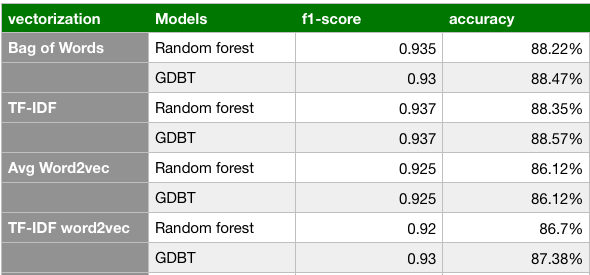

1. We have vectorized dataset into Bag of words , tf-idf , Avg Word2ved , tf-idf word2vec and applied random forest and GDBT
2. Both almost perform same on all vectorizer(GDBT performs slightly better than Random forest in this data)
3. We got best performance with TF-IDF with f1 score of 0.93.5
4. We will not use Word2vec model as it is only predicting positive class which is majority class
5. Random Forest / GDBT are not good option when dimensions are high , in such cases we have got better result with Logistic regression